# Import Libraries and Define Constants

In [ ]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Transfer Images via Google Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
content_path = '/content/drive/MyDrive/Mini Project - NST - Group 6/content/content_6.jpg'
style_path = '/content/drive/MyDrive/Mini Project - NST - Group 6/style/style_6.jpg'

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [ ]:
def load_img(path_to_img):
  max_dimension = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dimension / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

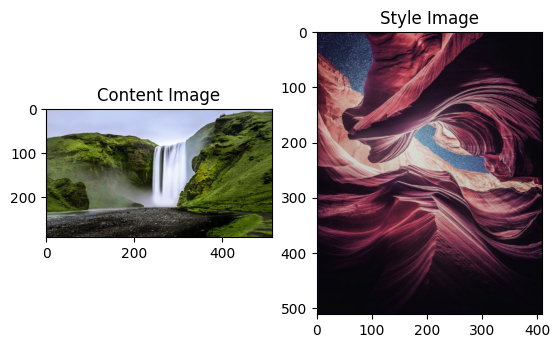

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Loading Pre - trained VGG 19

Preprocess and resize the content image

In [ ]:
pre_processed_content_img = tf.keras.applications.vgg19.preprocess_input(content_image*255)
pre_processed_content_img = tf.image.resize(pre_processed_content_img, (224, 224))

Load the VGG19 netowrk with Classification Heads and Get the prediction probabilities

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(pre_processed_content_img)
prediction_probabilities.shape

574710816/574710816 [==============================] - 29s 0us/step


TensorShape([1, 1000])

Print Top  Predictions

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('valley', 0.8376514),
 ('cliff', 0.11403422),
 ('dam', 0.01410634),
 ('promontory', 0.010938888),
 ('castle', 0.0072470354)]

Load VGG19 without Classification Head

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


Intermediate layers Choosen from the network to represent the style and content of the image

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

len_content_layers = len(content_layers)
len_style_layers = len(style_layers)

# Build Model

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 409, 64)
  min:  0.0
  max:  727.2921
  mean:  18.846676

block2_conv1
  shape:  (1, 256, 204, 128)
  min:  0.0
  max:  2695.7273
  mean:  102.72019

block3_conv1
  shape:  (1, 128, 102, 256)
  min:  0.0
  max:  5923.796
  mean:  112.339775

block4_conv1
  shape:  (1, 64, 51, 512)
  min:  0.0
  max:  15870.3125
  mean:  424.6164

block5_conv1
  shape:  (1, 32, 25, 512)
  min:  0.0
  max:  2262.1072
  mean:  35.87713



# Calculate Style

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return result / (num_locations)

# Extract Style & Content from the image

StyleContentModel - return the style and content tensors which are the style and content representations of the given input image

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  # we define call such that we will be returned the gram-matrices representing the style of the image 
  # and, the content of the image will be returned
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [ ]:
style_content_extractor = StyleContentModel(style_layers, content_layers)

# Get Target Content and Style

With **StyleContentModel** which is a style and content extractor, we can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Let us set the style and content target values. We shall do this by extracting the style of the style image and content of the content image.


In [ ]:
style_targets = style_content_extractor(style_image)['style']
content_targets = style_content_extractor(content_image)['content']

# Define Hyperparameters

Define style weight and content weight

In [ ]:
style_weight = 1e-2
content_weight = 1e4

Define Adam Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Function **clip_0_1** that would clip the values of image pixels to be in between 0 and 1 since this is a float image.

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

* Define the variable **image** which we would be  using further to update its pixels throughout the train-steps in the coming slides.

* We shall assign the tf.Variable(content_image) to the image. We use tf.Variable since the pixel values of this image are to be **updated through the gradient descent.**

In [ ]:
image = tf.Variable(content_image)

# Define Loss Function

In [ ]:
def style_content_loss(extractors):
    style_outputs = extractors['style']
    content_outputs = extractors['content']
    # tf.reduce_mean - computes the mean of elements across dimensions of a tensor.
    # tf.add_n adds all input tensors element-wise.
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len_content_layers
    loss = style_loss + content_loss
    return loss

# Run Gradient Descent

**train_step(image)** function which performs the calculation of gradient and updation of image pixel values for each train step epoch.

In [ ]:
total_variation_weight = 30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = style_content_extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)
    # print(type(loss))
    # print("Loss: {}".format(tf.print(loss)))

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

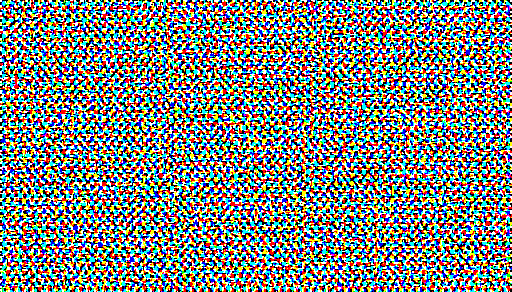

Train step: 4000
Total time: 243.0


In [ ]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 200

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Save Image

In [ ]:
result_path = '/content/drive/MyDrive/Mini Project - NST - Group 6/results/'

In [ ]:
file_name = str(time.asctime( time.localtime(time.time()))) + '_stylized-image.png'
output_image = tensor_to_image(image)
# tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  # files.download(file_name)
  output_image.save(result_path + file_name)

# Measurement Scoring

**Color Score**
<br>
"Measuring Colorfulness in Natural Images" 
By K. Radhakrishnan and A. C. Bovik 
Published in the IEEE Transactions on Image Processing in 2014.


The paper defines colorfulness as the degree to which colors in an image stand out relative to their surroundings. To measure colorfulness, the paper proposes a new method that computes a single score based on the distribution of color information in the image.

The method starts by splitting the image into its red, green, and blue (RGB) channels. The paper notes that the human visual system is most sensitive to changes in color information along the red-green and blue-yellow axes, so it computes two chromatic channels that capture these color differences:

rg channel: This channel measures the difference between the red and green channels. It is computed as the absolute value of the difference between the red and green channels.
yb channel: This channel measures the difference between the blue channel and the average of the red and green channels. It is computed as the absolute value of half the difference between the sum of the red and green channels and the blue channel.
The paper notes that these two chromatic channels capture most of the color information in natural images, and that they are relatively independent of luminance.

Next, the paper computes the mean and standard deviation of each chromatic channel. The mean captures the overall level of colorfulness in the image, while the standard deviation captures the variation of colorfulness across the image. The paper notes that natural images tend to have low mean and high standard deviation in the chromatic channels.

To combine the mean and standard deviation into a single score, the paper proposes a formula that adds the standard deviation to a weighted version of the mean:

colorfulness = std_root + (0.3 * mean_root)

where std_root is the square root of the sum of the squares of the standard deviations of the two chromatic channels, and mean_root is the square root of the sum of the squares of the means of the two chromatic channels. The weight of 0.3 for the mean is chosen to balance the relative importance of mean and standard deviation.

Finally, the paper validates the proposed method by comparing it to several existing colorfulness metrics on a large dataset of natural images. The paper shows that the proposed method outperforms the other metrics in terms of correlation with human judgments of colorfulness.

In summary, the method proposed in the "Measuring Colorfulness in Natural Images" paper computes a single colorfulness score for an image based on the distribution of color information in the image. The method captures the differences in color along the red-green and blue-yellow axes, and combines the mean and standard deviation of these differences into a single score. The method is shown to perform well on a large dataset of natural images.

In [ ]:
import cv2
import numpy as np

def calculate_colorfulness(image):
    # Split the image into its RGB channels
    (B, G, R) = cv2.split(image.astype("float"))

    # Compute rg and yb, the chromatic channels
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)

    # Compute the mean and standard deviation of both chromatic channels
    (rb_mean, rb_std) = (np.mean(rg), np.std(rg))
    (yb_mean, yb_std) = (np.mean(yb), np.std(yb))

    # Combine the mean and standard deviation into a single score
    std_root = np.sqrt((rb_std ** 2) + (yb_std ** 2))
    mean_root = np.sqrt((rb_mean ** 2) + (yb_mean ** 2))
    colorfulness = 10 - (std_root + (0.3 * mean_root))

    # Return the colorfulness score
    return colorfulness


**Texture Score**


The texture analysis method proposed in **"A Texture Analysis Method for Art Paintings" by Banerjee et al.** is based on Gabor filters, which are used to extract texture features from art paintings.

The Gabor filters are designed to capture different aspects of texture, such as scale and orientation. A Gabor filter is defined by several parameters, including the scale, orientation, and spatial frequency. The scale determines the size of the filter, while the orientation determines the angle at which the filter is applied. The spatial frequency determines the number of cycles in the filter.

In the paper, the Gabor filters are generated using a log-Gabor function, which is a modified version of the traditional Gabor function. The log-Gabor function is defined as:

G(u, v) = exp(-(log(u/u0))^2 / (2log(sigma)^2) - (log(v/v0))^2 / (2log(sigma)^2)) * exp(j2pi*log(u/f0))

where u and v are the spatial frequencies, u0 and v0 are the center frequencies, sigma is the bandwidth, f0 is the center frequency, and j is the imaginary unit.

To calculate the texture score, the paper proposes a method based on the Gabor filter responses. For each filter, the image is convolved with the filter, and the response is computed as the mean of the absolute values of the filter coefficients. The texture score is then calculated as the sum of the responses for all filters, normalized by the number of filters. This score is used to compare the texture features of different paintings. **This will result in a higher texture score for images with more complex textures, which can be interpreted as better quality**

The paper also proposes a method to reduce the dimensionality of the feature space using principal component analysis (PCA). PCA is used to find the principal components of the feature space, which are the directions of maximum variation. By projecting the feature vectors onto the principal components, the dimensionality of the feature space can be reduced. This method is used to reduce the number of features and to improve the performance of the texture analysis method.

Overall, the texture analysis method proposed in the paper is based on Gabor filters and is designed to capture the texture features of art paintings. The method calculates a texture score based on the Gabor filter responses and can be used for tasks such as image classification and retrieval.

In [ ]:
import cv2
import numpy as np


def calculate_texture_score(img_path, num_scales=4, num_orientations=4):
    # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Initialize the texture score
    score = 0.0

    # Calculate the Gabor filter bank
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / num_orientations):
        for sigma in np.logspace(0, np.log10(ksize), num_scales):
            for lamda in np.logspace(-1, 1, num_scales):
                for gamma in np.linspace(0.2, 1.0, num_scales):
                    kernel = cv2.getGaborKernel(
                        (ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F
                    )
                    kernel /= 1.5 * kernel.sum()
                    filters.append(kernel)

    # Apply the Gabor filters to the image and calculate the texture score
    for kernel in filters:
        filtered = cv2.filter2D(img, cv2.CV_32F, kernel)
        score += np.mean(filtered)

    # Normalize the texture score by the number of filters
    score /= len(filters)

    return score

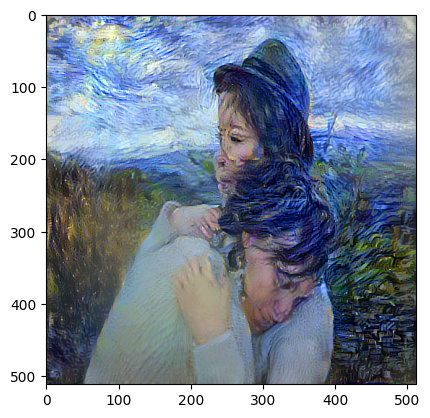

In [ ]:
# Load the image
cnn_style_path = '/content/drive/MyDrive/Mini Project - NST - Group 6/compare_result/content1_style_van.png'
image = cv2.imread(cnn_style_path)

img2 = image[:,:,::-1]
plt.imshow(img2)

In [ ]:
# Calculate the colorfulness score
colorfulness = calculate_colorfulness(image)
print(f"Colorfulness score: {colorfulness:.2f}")

Colorfulness score: -37.35


In [ ]:
score = calculate_texture_score(cnn_style_path)
print(f"Texture score: {score:.2f}")

Texture score: 39.94
